# Field inference for multiple dipole sources

This notebook demonstrates that it is possible to learn analytical forms like the dipole field with good accuracy with a physically credible network and desirable scaling behaviour. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [3]:
import jax.random as jr
from hypermagnetics import plots
from hypermagnetics.sources import configure

## I. Target definition and data generation

We expect the neural components of the model to learn transcendental functions. The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\sum_{i=1}^N \underbrace{\overbrace{\frac{1}{2\pi |\mathbf{r}-\mathbf{r_i}|}}^{\text{Surface of 2D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\psi_i}$$. 

A realistic (non-pointlike) source will have, in two dimensions, the form $\mathbf{H}(\mathbf{r}) = - \mathbb{N}(\mathbf{r})\mathbf{M}$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it. The distinguishing feature of the dipole term is the $\sim 1/r$ dependence; higher multipole terms ($1/r^2$, $1/r^3$) might also be included, but the dipole term will quickly dominate at larger $r$. 

We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

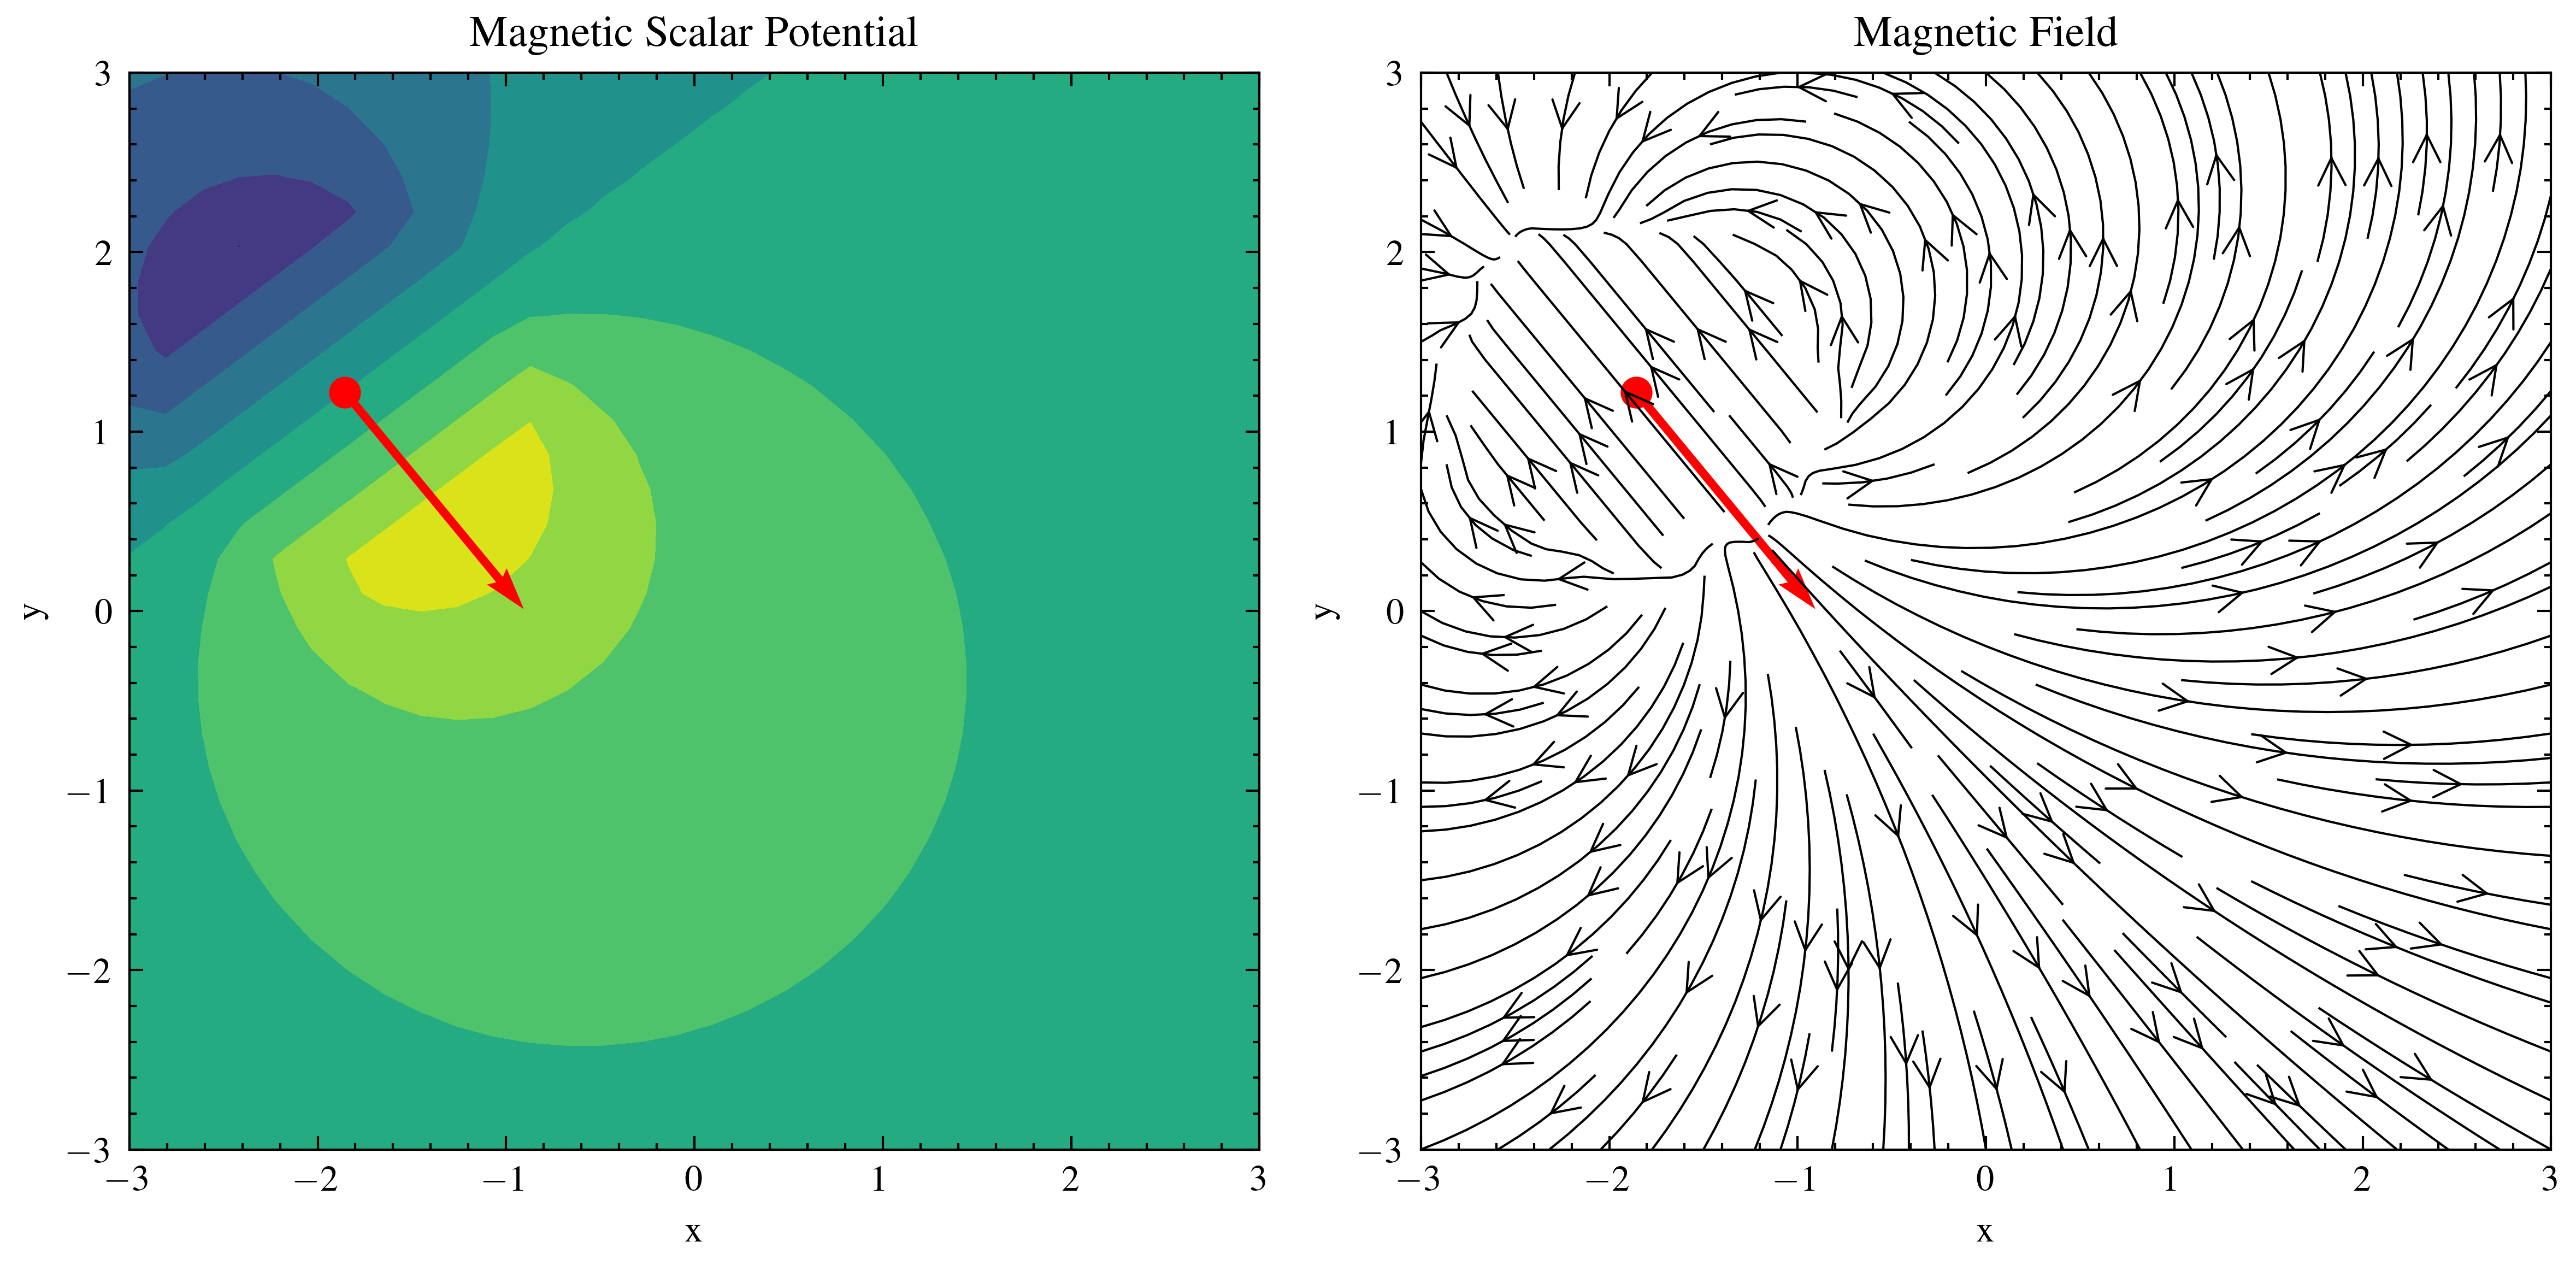

In [5]:
configuration = configure(
    **{
        "n_samples": 10,
        "n_sources": 1,
        "key": jr.PRNGKey(40),
        "lim": 3,
        "res": 32,
    }
)

plots(configuration, model=None)

In [6]:
ORDER = 16
omega = 2 * jnp.pi * jnp.arange(1, ORDER + 1) / (4 * lim)
r = flat_grid


def basis_term(fun1, fun2, r):
    return fun1(omega[:, None, None] * r[None, :, 0]) * fun2(
        omega[None, :, None] * r[None, :, 1]
    )


BASIS_TERMS = jnp.stack(
    [
        basis_term(jnp.cos, jnp.cos, r),
        basis_term(jnp.sin, jnp.sin, r),
        basis_term(jnp.cos, jnp.sin, r),
        basis_term(jnp.sin, jnp.cos, r),
    ],
    axis=0,
)

In [7]:
class HyperModel(eqx.Module):
    w: eqx.nn.MLP
    b: eqx.nn.Linear

    def __init__(self, out, width, depth, keys):
        self.w = eqx.nn.MLP(4, out, width, depth, jax.nn.gelu, key=keys.pop())
        self.b = eqx.nn.Linear(4, "scalar", key=keys.pop())

    def __call__(self, m_r):
        return self.w(m_r), self.b(m_r)


class FourierModel(eqx.Module):
    hypermodel: HyperModel

    def __init__(self, width, keys):
        self.hypermodel = HyperModel(4 * ORDER**2, width, 3, keys)

    def fourier(self, weights, bias, basis_terms=BASIS_TERMS):
        weights = jnp.reshape(weights, (4, ORDER, ORDER))
        elementwise_product = weights[..., None] * basis_terms
        summed_product = jnp.sum(elementwise_product, axis=(0, 1, 2))
        return bias + summed_product

    def prepare_weights(self, m, r0):
        m_r = jnp.concatenate([m, r0], axis=-1)
        w, b = jax.vmap(jax.vmap(self.hypermodel))(m_r)
        return jnp.sum(w, axis=1), jnp.sum(b, axis=1)

    def predict(self, m, r0, r):
        w, b = self.prepare_weights(m, r0)
        basis_terms = jnp.stack(
            [
                basis_term(jnp.cos, jnp.cos, r),
                basis_term(jnp.sin, jnp.sin, r),
                basis_term(jnp.cos, jnp.sin, r),
                basis_term(jnp.sin, jnp.cos, r),
            ],
            axis=0,
        )
        return jax.vmap(self.fourier, in_axes=(0, 0, None))(w, b, basis_terms)

    def __call__(self, m, r0):
        return jax.vmap(self.fourier)(*self.prepare_weights(m, r0))


@eqx.filter_jit
def loss(model, m, r0, target):
    return jnp.mean(optax.huber_loss(model(m, r0), target))


@eqx.filter_jit
def accuracy(model, m, r0, r, target):
    diff = jnp.abs(target - model.predict(m, r0, r))
    return jnp.median(diff / jnp.abs(target) * 100, axis=1).mean()

In [8]:
key = jr.PRNGKey(42 + 1)
key, *keys = jr.split(key, 5)
width = ORDER * ORDER
model = FourierModel(width, keys)

In [9]:
print(model(m, r0).shape)
print(loss(model, m, r0, potential))
print(accuracy(model, m, r0, flat_grid, potential))
model.predict(m[0:1], r0[0:1], jnp.array([[1.0, 2.0]]))

(10, 1024)
0.28946778
1133.7299


Array([[0.6799417]], dtype=float32)

In [10]:
@eqx.filter_jit
def train_step(model, opt_state, m, r0, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, m, r0, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


def validation_set(model, subkey):
    m, r0 = jnp.split(jr.normal(key=subkey, shape=(N, M, 4)), 2, axis=-1)
    r = jr.uniform(minval=-lim, maxval=lim, shape=(res * res, 2), key=subkey)
    potential = generate_total(scalar_potential, m, r0, r)
    return accuracy(model, m, r0, r, potential)


optim = optax.adam(learning_rate=1e-4)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

steps = 5_000
logger = {"train_loss": [], "train_acc": [], "val_acc": []}
for step in range(steps):
    key, subkey = jr.split(key, 2)
    r = jr.uniform(minval=-lim, maxval=lim, shape=(res * res, 2), key=subkey)
    model, opt_state, train_loss = train_step(model, opt_state, m, r0, potential)
    if (step % (steps / 100)) == 0:
        logger["train_loss"].append(train_loss)
        logger["train_acc"].append(accuracy(model, m, r0, flat_grid, potential))

        # Generate validation data
        key, subkey = jr.split(key, 2)
        logger["val_acc"].append(validation_set(model, subkey))
    if (step % (steps / 10)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"accuracy={logger['train_acc'][-1]:.4f}",
            f"val_accuracy={logger['val_acc'][-1]:.4f}",
        )

key, subkey = jr.split(key, 2)
rge = validation_set(model, subkey)
print(f"Final accuracy: {rge:.2f}%")

step=0, train_loss=0.2895,  accuracy=1100.5490 val_accuracy=1031.3002
step=500, train_loss=0.0001,  accuracy=19.3983 val_accuracy=181.5947
step=1000, train_loss=0.0000,  accuracy=9.7378 val_accuracy=309.0800
step=1500, train_loss=0.0000,  accuracy=6.8997 val_accuracy=179.0734
step=2000, train_loss=0.0000,  accuracy=4.9893 val_accuracy=235.4346
step=2500, train_loss=0.0000,  accuracy=3.9532 val_accuracy=166.5441
step=3000, train_loss=0.0000,  accuracy=3.2587 val_accuracy=269.0009
step=3500, train_loss=0.0000,  accuracy=2.8197 val_accuracy=278.5486
step=4000, train_loss=0.0000,  accuracy=2.5811 val_accuracy=398.7151
step=4500, train_loss=0.0000,  accuracy=2.2968 val_accuracy=172.7899
Final accuracy: 133.93%


In [11]:
plots(configuration, model=model)

TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 2 for shapes (10, 1, 4), (10, 1024, 2).

In [ ]:
pred_potential = model(m, r0)
tmp_field = lambda m, r0, r: jax.grad(model.fourier)(r, *model.hypermodel(m, r0))
# pred_field = -jax.vmap(
#     jax.vmap(tmp_field, in_axes=(None, None, 0)), in_axes=(0, 0, None)
# )(m, r0, flat_grid)

idx = 0
plots(
    x_grid,
    y_grid,
    m,
    r0,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
    idx=idx,
)

plots(
    x_grid,
    y_grid,
    m,
    r0,
    pred_potential.reshape(N, res, res),
    field=None,
    idx=idx,
)

In [ ]:
N_val = 1
M_val = 4

key = jr.PRNGKey(100 + 1)
key, sk1, sk2 = jr.split(key, 3)
m_val, r0_val = jnp.split(jr.normal(key=sk1, shape=(N_val, M_val, 4)), 2, axis=-1)
r_val = flat_grid  # jr.uniform(minval=-lim, maxval=lim, shape=(res * res, 2), key=sk2)
val_potential = generate_total(scalar_potential, m_val, r0_val, r_val)
pred_potential = model.predict(m_val, r0_val, r_val)

plots(x_grid, y_grid, m_val, r0_val, val_potential.reshape(N_val, res, res), field=None)

plots(
    x_grid, y_grid, m_val, r0_val, pred_potential.reshape(N_val, res, res), field=None
)